# Shifted-tilted Tophat at Gaussian interference at waist

Applying first-order shift,tilt to tophat, integrate with HG00

\begin{equation}
	u_{n,m} \rightarrow
     u_{n,m}
        \left[
        1 - \frac{2 a }{w(z)^2} x + i k \alpha x - i \frac{2 k \alpha a}{w(z)^2} x^2 
    \right]
    + 
	a \frac{2 \sqrt{n}}{w(z)} 
	\exp(i \Psi(z))
	u_{n-1,m}
	\left[
        1+ i k \alpha x
    \right]	 \; .
\end{equation}

Scatter these with

\begin{align*}
\sum_{n,m} u_{n,m} \rightarrow 
	\sum_{n,m} 
	\lbrace &
		u_{n+2,m}[ X_+^2(-i\frac{2ka\alpha}{w^2})]
		\\+&
		u_{n+1,m}[ X_+^1(ik\alpha - \frac{2a}{w^2})]
		\\+&
		u_{n,m} [1+X_+^1(ik\alpha \frac{2a\sqrt{n}}{w} e^{i\Psi})- X_0^2 (i\frac{2ka\alpha}{w^2})]
		\\+&
		u_{n-1,m} [\frac{2a\sqrt{n}}{w} e^{i\Psi} + X_-^1(ik\alpha - \frac{2a}{w^2})]
		\\+&
		u_{n-2,m} [ X_-^1(ik\alpha a\frac{2\sqrt{n}}{w}e^{i\Psi}) - X_-^2 (i\frac{2ka\alpha}{w^2})] 	
	\rbrace
\end{align*}

In [1]:
import PauLisa as pl, PL_Plot as plplt,plback as plb, Tophat_integration_AW as th, numpy as np, matplotlib.pyplot as plt, cmath as cm

from numpy import pi as pi
from numpy import angle
from math import e
from numpy import sqrt as sqrt
from scipy.special import erf as erf
import mpmath as mp
import scipy.io

from math import pi, log, exp, sin, cos, atan, e, radians, degrees
from scipy.special import gamma as gamma
from scipy.special import erf as erf
from math import factorial as fact
import cmath
from cmath import sqrt as sqrt
import numpy as np

from time import process_time

inf=np.inf

import pandas as pd

## Tophat coeffients from AW

In [2]:
mat = scipy.io.loadmat('Top_hat_for_paul.mat')
coef=mat['coeftop'].ravel()

def N_f(A):
    
    res = np.floor((np.sqrt(8*A+1)-1)/2)
    
    #res = (np.sqrt(9+8*A)-3)/2
    return(res)

def m(N,A):
    res = (N+1)*(N+2)/2 - (A+1)
    return(res)

#def n(N,A):
#    m= (N+1)*(N+2)/2 - (A+1)
#    res = N-m
#    return(res)
def n(N,A):
    res = A - (N*(N+1)/2)
    return(res)

NumberModes = int(len(coef))
listModesN = [None] * NumberModes
listModesM = [None] * NumberModes
listModesC = [None] * NumberModes

area = pi*1e-3**2

#for i in range(len(coef)):
#    A=i
#    N= N_f(A)
#
#    if (m(N,A)%2 == 0) & (n(N,A)%2 == 0):
#        print(coef[A], '\t\t\t' , m(N,A), ',' , n(N,A))

for i in range(NumberModes):
    A=i
    N= N_f(A)
    listModesN[i] = int(m(N,A))
    listModesM[i] = int(n(N,A))
    listModesC[i] = coef[i]/sqrt(area)
    
    

In [3]:


modes = pl.create_modes(listModesM,listModesN,listModesC,NumberModes)

N=28 # mode order
modes_N= pl.create_modes_orderN(listModesM,listModesN,listModesC,NumberModes,N)




In [4]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes):   

    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                res += c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y)
                #print( 'n,m:',a,b,th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y))
                
    return(res)

## Integration for signals

In [5]:
#initial beam params

lam = 1064e-9


z_PD = 0e-3 #PD location
z = z_PD #prop distance assumed PD

z_m = 0 #meas beam 
Z = z_PD - z_m #distance PD-m

z_LO = 0 #Local ref. beam
d_1 = z_PD - z_LO #distance PD-LO


Y = 2e-3 #Y int bound

x_1R = 20e-6
x_2R = 2e-3 

x_1L = -(x_2R) #assumed symmetric with right side
x_2L = -(x_1R)

w_1 = 1e-3 #waist LO 
w_2 = 0.00023067 #waist MS

zR_1 = pi*w_1**2/lam #rayleigh LO
zR_2 = pi*w_2**2/lam


k_1 = 5905249.348852994 #wavenum LO
k_2 = 5905249.348852994

params = pl.Params(lam,w_2,Z) #for building tophat coefficients

W_2 = pl.w(z,params) #tophat beam rad , w(z) or 1e-3?



#integration and misalignment
points = 51

a = 0
alpha_arr = np.linspace(-500e-6,500e-6,points)

modes_arr = [0]*points

#build modes from misalignments
for p in range (points):
    modes_arr[p] = pl.scatter_case2_first_order(z,params,a,alpha_arr[p],modes) #array of array of scattered modes#array of array of scattered modes


In [6]:

time_start = process_time()

time_ave = 0

#modes_arr = [0]*points
cl = [0]*points
cr = [0]*points
phi_l = [0]*points
phi_r = [0]*points
dws = [0]*points
lps = [0]*points


#alpha_arr = np.linspace(-500e-6,500e-6,points)

for p in range (points):
    #modes_arr[p] = pl.scatter_case2_first_order(z,params,a,alpha,modes18) #array of array of scattered modes#array of array of scattered modes
    time_ave_start = process_time()
    
    cl[p] = iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1L,x_2L,Z,Y,modes_arr[p]) # left overlap (-2e-3,0)
    time_ave += (process_time()-time_ave_start)
    cr[p] = iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1R,x_2R,Z,Y,modes_arr[p]) # right overlap (0,2e-3)
    
    

    phi_r[p]=angle(cr[p])
    phi_l[p]=angle(cl[p])
    
    dws[p] = phi_r[p]-phi_l[p]
    lps[p] = 0.5*(phi_r[p]+phi_l[p])
    
time_elapsed = (process_time() - time_start)
print(time_elapsed,'s')
print(time_ave/p,'s')


47.8125 s
0.4815625 s


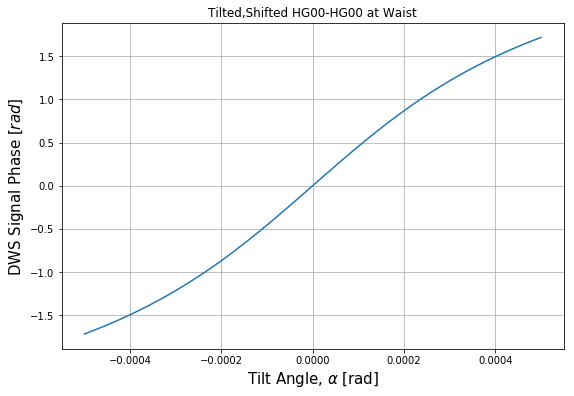

In [7]:
plt.figure(figsize=(9,6))
plt.plot(alpha_arr, dws)

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'DWS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'Tilted,Shifted HG00-HG00 at Waist') 

plt.grid()

#plt.savefig("4-28_HG00_dws.png")

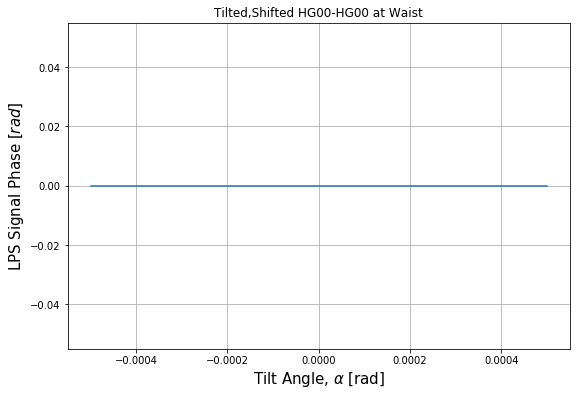

In [8]:
plt.figure(figsize=(9,6))
plt.plot(alpha_arr, lps)

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'LPS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'Tilted,Shifted HG00-HG00 at Waist') 

plt.grid()

#plt.savefig("4-28_HG00_lps.png")

In [9]:
m=2
stop = int((m/2-1)+1)
sum_M = sum([
           ( fact(M+1)/fact(2*(M+1))
        *(2*1)**(2*M+1) )
           for M in range(0, stop,1)])
print(sum_M)

1.0


In [10]:
stop = int((4/2-1)+1)
sum_M = sum([
           1**M
           for M in range(stop-1, stop,1)])
print(sum_M)

1
